In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

In [ ]:
lit_period = 51.4213
lit_t0 = 2458901.6949978997
t0 = lit_t0

In [ ]:
x, y, yerr = np.loadtxt('data/photometry/tess_corrected.txt',usecols=(0,1,2)).T
x += 2457000

# m = (x < t0+1) & (x > t0-1)
# t1 = x[~m][np.argmin(y[~m])]

# m |= (x < t1+1) & (x > t1-1)

# # x = x[m]
# # y = y[m]

x = np.ascontiguousarray(x, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

plt.plot((x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period, y, ".k")
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.xlabel("time since primary eclipse [days]")
_ = plt.ylabel("relative flux [ppt]")

In [ ]:
# fold_hip =  hip_t % lit_period / lit_period
# fold_tess = x % lit_period / lit_period
# fold_asasn = asasn_t % lit_period / lit_period
# plt.plot(fold_tess, y /1e3 + 1, ',k')
# plt.plot(fold_hip, hip_y, '.')
# # plt.plot(fold_asasn, asasn_y, '.')

# # plt.xlim(0.6, 0.8)
# # plt.ylim(0.8, 1.2)

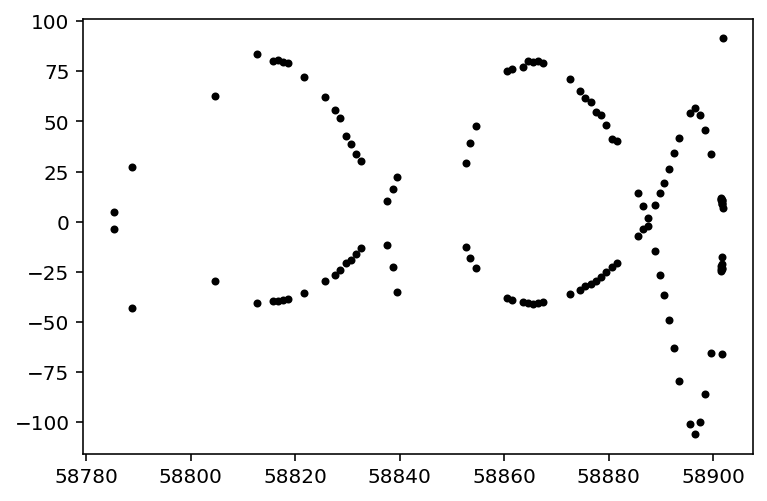

In [5]:
ref_rv = 2400000

x_rv_primary, y_rv_primary = np.loadtxt('data/RV/SONG.txt', usecols=(0,1)).T
x_rv_secondary, y_rv_secondary = np.loadtxt('data/RV/SONG_secondary.txt', usecols=(0,1)).T

plt.plot(x_rv_primary, y_rv_primary, '.k')
plt.plot(x_rv_secondary, y_rv_secondary, '.k')

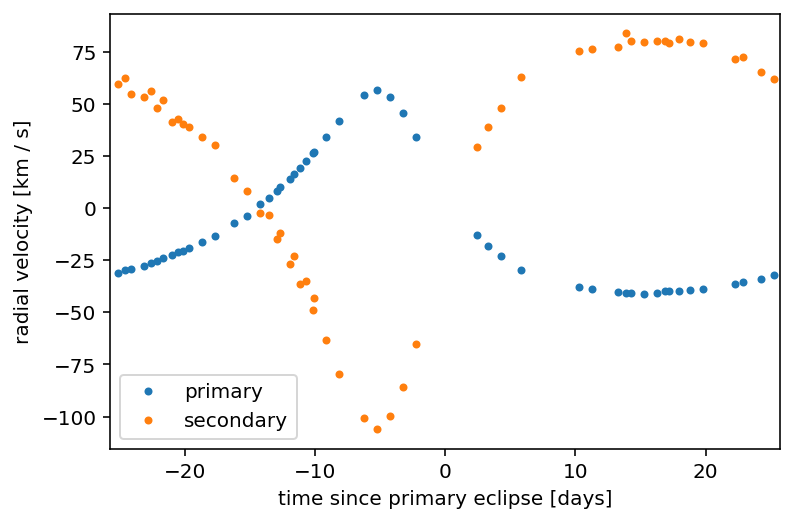

In [6]:
x_rv = np.ascontiguousarray(x_rv_primary + ref_rv, dtype=np.float64)
y1_rv = np.ascontiguousarray(y_rv_primary, dtype=np.float64)
# y1_rv -= np.median(y1_rv)
y2_rv = np.ascontiguousarray(y_rv_secondary, dtype=np.float64)
# y2_rv -= np.median(y2_rv)


fold = (x_rv - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period

m = (fold < 1) & (fold > -1)
x_rv = x_rv[~m]
y1_rv = y1_rv[~m]
y2_rv = y2_rv[~m]
fold = (x_rv - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period


plt.plot(fold, y1_rv, ".", label="primary")
plt.plot(fold, y2_rv, ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

Text(0.5, 0, 'Orbital phase')

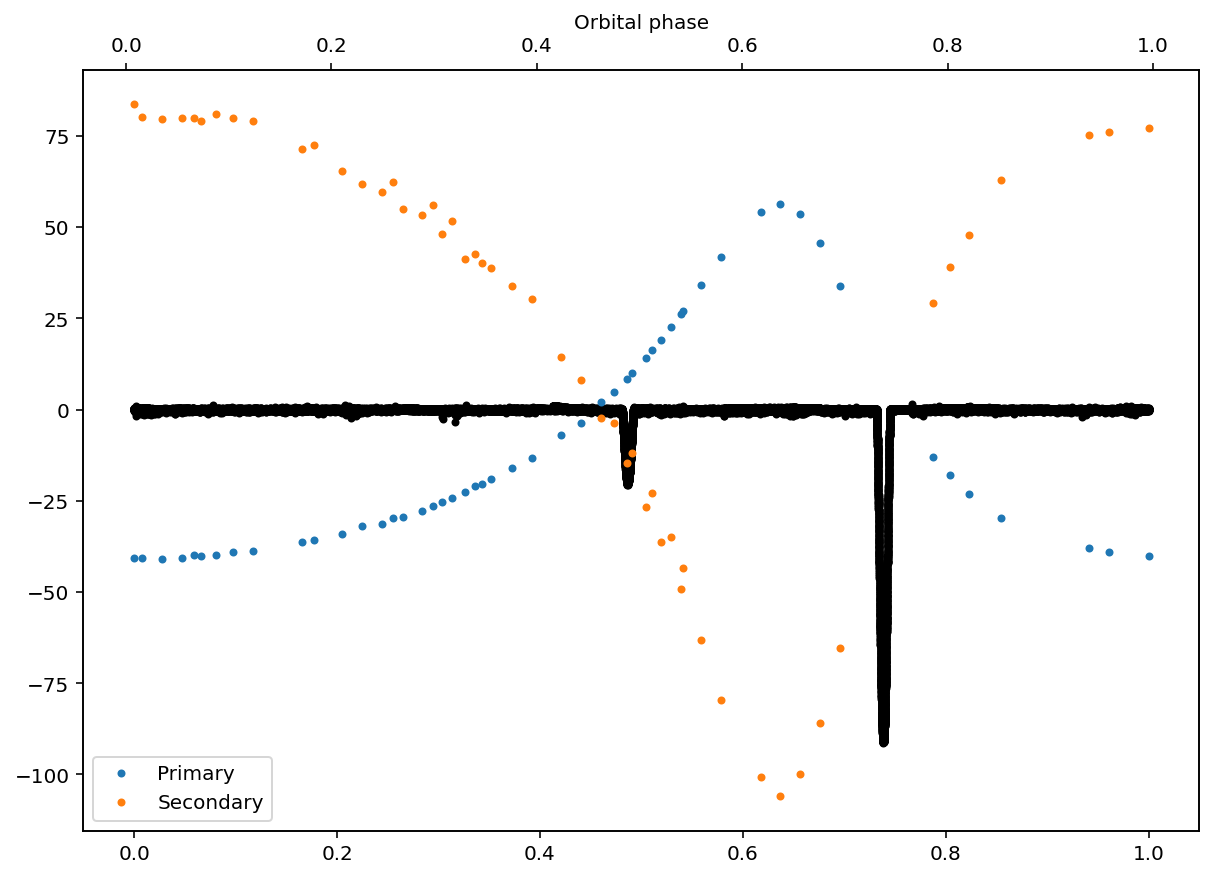

In [7]:
plt.figure(figsize=[10,7])

plt.plot(x % lit_period / lit_period, y, '.k')
ax2 = plt.twiny()
ax2.plot(x_rv % lit_period / lit_period, y1_rv, '.', label='Primary')
ax2.plot(x_rv % lit_period / lit_period, y2_rv, '.', label='Secondary')
plt.legend()

plt.xlabel('Orbital phase')
# plt.savefig('joint.png', dpi=300, bbox_inches='tight')

In [8]:
lit_flux_ratio = ((0.674)**3.5, 0.2)

In [9]:
e = 0.41346
w = 0.2786
e*np.cos(w), e*np.sin(w)

(0.3975175588699947, 0.11370559348616191)

In [10]:
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo


def build_model(mask):

    with pm.Model() as model:

        # Systemic parameters
#         mean_lc = pm.Normal("mean_lc", mu=0.0, sd=5.0)
        mean_rv1 = pm.Normal("mean_rv1", mu=0.0, sd=50.0)
        mean_rv2 = pm.Normal("mean_rv2", mu=0.0, sd=50.0)
#         u1 = xo.QuadLimbDark("u1")
#         u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        M1 = pm.Lognormal("M1", mu=0.0, sd=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sd=10.0)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sd=10.0)  # radius ratio
        q = pm.Lognormal("q", mu=0.0, sd=10.0)  # mass ratio
        s = pm.Lognormal("s", mu=np.log(0.5), sd=10.0)  # surface brightness ratio

        # Prior on flux ratio
        pm.Normal(
            "flux_prior",
            mu=lit_flux_ratio[0],
            sd=lit_flux_ratio[1],
            observed=k ** 2 * s,
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=1.5)
        period = pm.Lognormal("period", mu=np.log(lit_period), sd=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sd=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = xo.UnitDisk("ecs", testval=np.array([0.3975175588699947, 0.11370559348616191]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
#         sigma_lc = pm.InverseGamma(
#             "sigma_lc", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.1, 2.0)
#         )
#         S_tot_lc = pm.InverseGamma(
#             "S_tot_lc", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
#         )
#         ell_lc = pm.InverseGamma(
#             "ell_lc", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
#         )
#         kernel_lc = xo.gp.terms.SHOTerm(
#             S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0 / 3
#         )

        # Noise model for the radial velocities
        sigma_rv1 = pm.InverseGamma(
            "sigma_rv1", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        sigma_rv2 = pm.InverseGamma(
            "sigma_rv2", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        S_tot_rv = pm.InverseGamma(
            "S_tot_rv", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_rv = pm.InverseGamma(
            "ell_rv", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_rv = xo.gp.terms.SHOTerm(
            S_tot=S_tot_rv, w0=2 * np.pi / ell_rv, Q=1.0 / 3
        )

        # Set up the light curve model
#         lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

#         def model_lc(t):
#             return (
#                 mean_lc
#                 + 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=t, 
# #                                            texp=texp
#                                           )[:, 0]
#             )

        
        
        # Condition the light curve model on the data
#         gp_lc = xo.gp.GP(
#             kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=model_lc
#         )
#         gp_lc.marginal("obs_lc", observed=y[mask])
#         pm.Normal('obs_lc', observed=y[mask], mu=model_lc(x[mask]), sd=sigma_lc ** 2)
        
        
        # Set up the radial velocity model
        def model_rv1(t):
            return mean_rv1 + 1e-3 * orbit.get_radial_velocity(t)

        def model_rv2(t):
            return mean_rv2 - 1e-3 * orbit.get_radial_velocity(t) / q

        # Condition the radial velocity model on the data
        gp_rv1 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv1 ** 2, mean=model_rv1
        )
        gp_rv1.marginal("obs_rv1", observed=y1_rv)
        gp_rv2 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv2 ** 2, mean=model_rv2
        )
        gp_rv2.marginal("obs_rv2", observed=y2_rv)

        # Optimize the logp
        map_soln = model.test_point

        # First the RV parameters
        map_soln = xo.optimize(map_soln, [mean_rv1,mean_rv2, q])
        map_soln = xo.optimize(
            map_soln, [mean_rv1,mean_rv2, sigma_rv1, sigma_rv2, S_tot_rv, ell_rv]
        )

        # Then the LC parameters
        map_soln = xo.optimize(map_soln, [R1, k, s, b])
        map_soln = xo.optimize(map_soln, [R1, k, s, b,])
#         map_soln = xo.optimize(map_soln, [S_tot_lc, ell_lc])
        map_soln = xo.optimize(map_soln, [t0, period])

        # Then all the parameters together
        map_soln = xo.optimize(map_soln)

#         model.gp_lc = gp_lc
#         model.model_lc = model_lc
        model.gp_rv1 = gp_rv1
        model.model_rv1 = model_rv1
        model.gp_rv2 = gp_rv2
        model.model_rv2 = model_rv2

        model.x = x[mask]
        model.y = y[mask]

    return model, map_soln


# def sigma_clip():
#     mask = np.ones(len(x), dtype=bool)
#     num = len(mask)

#     for i in range(3):
#         model, map_soln = build_model(mask)

#         with model:
#             mdl = xo.eval_in_model(
#                 model.model_lc(x[mask]) + model.gp_lc.predict(), map_soln
#             )

#         resid = y[mask] - mdl
#         sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
#         mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
#         print("Sigma clipped {0} light curve points".format(num - mask.sum()))
#         if num == mask.sum():
#             break
#         num = mask.sum()

#     return model, map_soln

mask = np.ones(len(x), dtype=bool)
model, map_soln = build_model(mask)

optimizing logp for variables: [q, mean_rv2, mean_rv1]


message: Optimization terminated successfully.
logp: -9346.273483121357 -> -5061.387636498601
optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv2, mean_rv1]


message: Optimization terminated successfully.
logp: -5061.3876364986 -> -352.17627663465385
optimizing logp for variables: [b, k, s, R1]


message: Optimization terminated successfully.
logp: -352.17627663465385 -> -351.076102248606
optimizing logp for variables: [b, k, s, R1]


message: Optimization terminated successfully.
logp: -351.076102248606 -> -351.076102248606
optimizing logp for variables: [period, t0]


message: Optimization terminated successfully.
logp: -351.076102248606 -> -346.91038574383833
optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ecs, t0, period, b, s, q, k, R1, M1, mean_rv2, mean_rv1]


message: Desired error not necessarily achieved due to precision loss.
logp: -346.91038574383833 -> -171.31904287193152


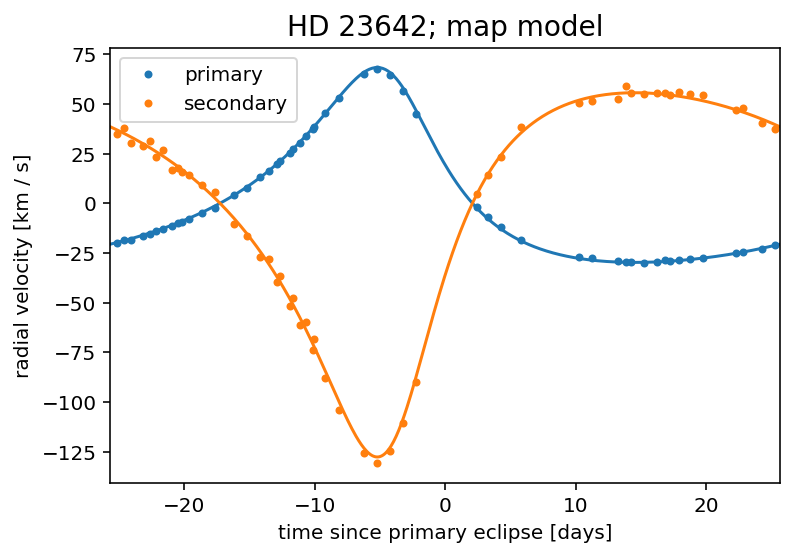

In [11]:
period = map_soln["period"]
t0 = map_soln["t0"]
# mean = map_soln["mean_rv"]

x_fold = (x_rv - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(fold, y1_rv - map_soln["mean_rv1"], ".", label="primary")
plt.plot(fold, y2_rv - map_soln["mean_rv2"], ".", label="secondary")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
with model:
    y1_mod, y2_mod = xo.eval_in_model(
        [model.model_rv1(x_phase + t0), model.model_rv2(x_phase + t0)], map_soln
    )
plt.plot(x_phase, y1_mod - map_soln["mean_rv1"], "C0")
plt.plot(x_phase, y2_mod - map_soln["mean_rv2"], "C1")

plt.legend(fontsize=10)
plt.xlim(-0.5 * period, 0.5 * period)
plt.ylabel("radial velocity [km / s]")
plt.xlabel("time since primary eclipse [days]")
_ = plt.title("HD 23642; map model", fontsize=14)

In [12]:
map_soln

{'mean_rv1': array(-11.15601),
 'mean_rv2': array(24.69519552),
 'M1_log__': array(1.9645042),
 'R1_log__': array(-0.00055824),
 'k_log__': array(-0.27477668),
 'q_log__': array(-0.6252469),
 's_log__': array(-0.83041689),
 'b_impact__': array(-5.72300508e-06),
 'period_log__': array(3.93842335),
 't0': array(2458901.66120121),
 'ecs_unitdisk+interval__': array([0.83093207, 0.36797334]),
 'sigma_rv1_log__': array(-1.15294749),
 'sigma_rv2_log__': array(0.07070594),
 'S_tot_rv_log__': array(0.38891931),
 'ell_rv_log__': array(3.91373158),
 'M1': array(7.13137594),
 'R1': array(0.99944192),
 'k': array(0.75974177),
 'q': array(0.53512929),
 's': array(0.43586754),
 'b': array(0.87986837),
 'period': array(51.33759598),
 'ecs': array([0.39310395, 0.16729123]),
 'ecc': array(0.42722017),
 'omega': array(0.40234899),
 'R2': array(0.75931777),
 'M2': array(3.81620814),
 'incl': array(1.56106777),
 'a': array(129.07265369),
 'sigma_rv1': array(0.31570486),
 'sigma_rv2': array(1.07326558),
 'S

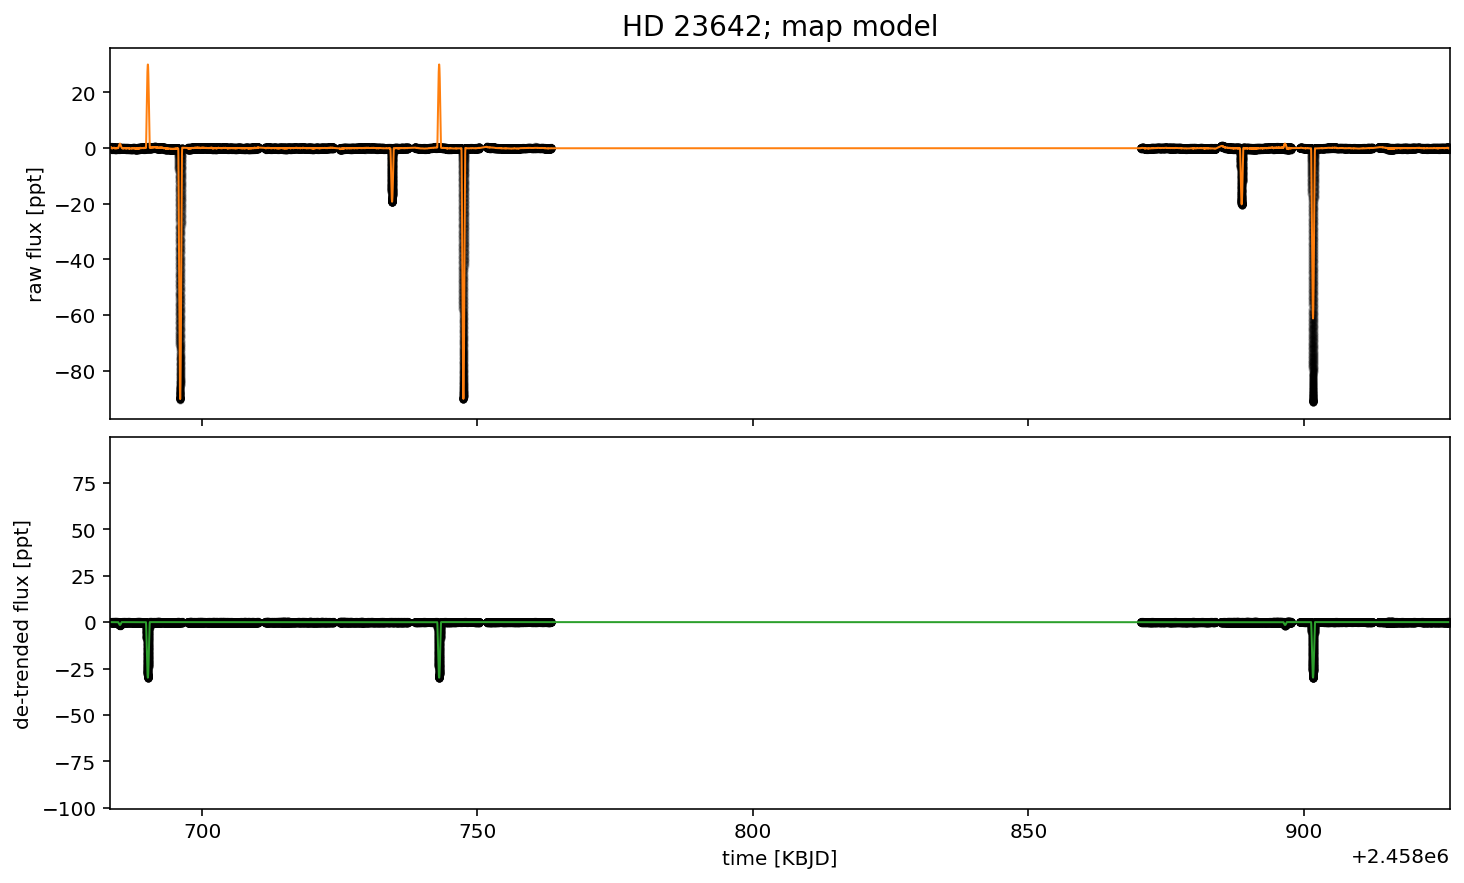

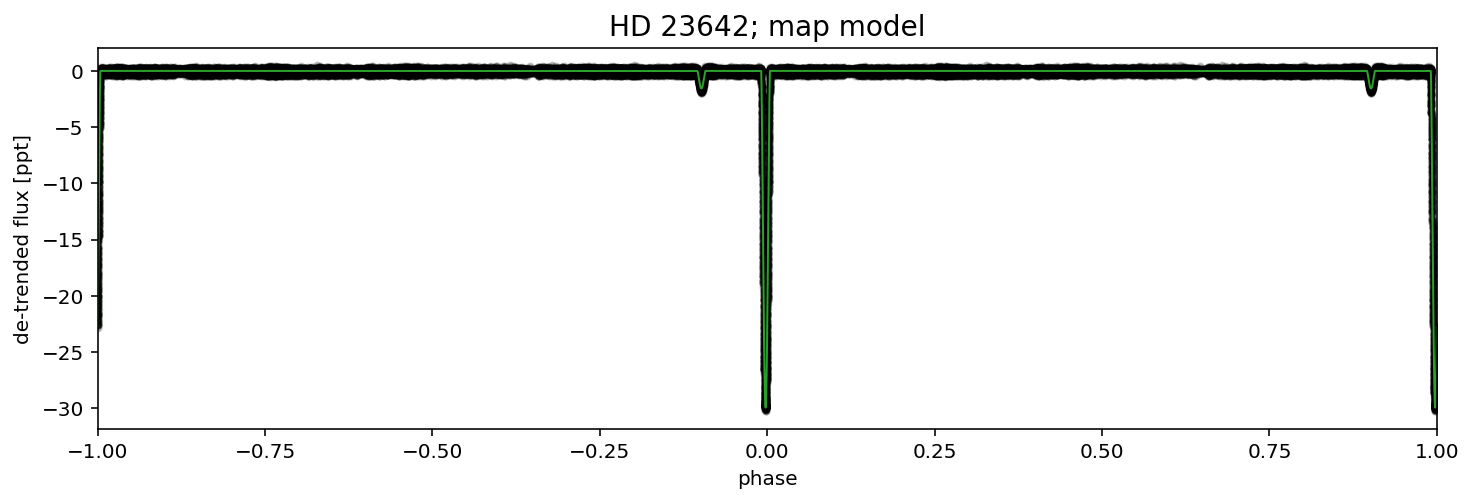

In [39]:
with model:
    gp_pred = xo.eval_in_model(model.gp_lc.predict(), map_soln) + map_soln["mean_lc"]
    lc = xo.eval_in_model(model.model_lc(model.x), map_soln) - map_soln["mean_lc"]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

ax1.plot(model.x, model.y, "k.", alpha=0.2)
ax1.plot(model.x, gp_pred, color="C1", lw=1)

ax2.plot(model.x, model.y - gp_pred, "k.", alpha=0.2)
ax2.plot(model.x, lc, color="C2", lw=1)
ax2.set_xlim(model.x.min(), model.x.max())

ax1.set_ylabel("raw flux [ppt]")
ax2.set_ylabel("de-trended flux [ppt]")
ax2.set_xlabel("time [KBJD]")
ax1.set_title("HD 23642; map model", fontsize=14)

fig.subplots_adjust(hspace=0.05)

fig, ax1 = plt.subplots(1, figsize=(12, 3.5))

x_fold = (model.x - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
inds = np.argsort(x_fold)

ax1.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax1.plot(x_fold[inds] - 1, model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax2.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2, label="data!")
ax2.plot(x_fold[inds] - 1, model.y[inds] - gp_pred, "k.", alpha=0.2)

yval = model.y[inds] - gp_pred
bins = np.linspace(0, 1, 75)
num, _ = np.histogram(x_fold[inds], bins, weights=yval)
denom, _ = np.histogram(x_fold[inds], bins)
ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

args = dict(lw=1)

ax1.plot(x_fold[inds], lc[inds], "C2", **args)
ax1.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

ax1.set_xlim(-1, 1)
ax1.set_ylabel("de-trended flux [ppt]")
ax1.set_xlabel("phase")
_ = ax1.set_title("HD 23642; map model", fontsize=14)